# Contracts Tutor – Figure I.1: Logistic Regression on Textual & Pedagogical Features

This notebook generates **Figure I.1** of the Contracts Tutor paper:

> *Estimated coefficients from a logistic regression of pairwise answer choices on differences in textual and pedagogical features, with two-way clustered standard errors (by judge and answer pair). Dots represent point estimates; horizontal lines show 95\% confidence intervals. Positive values indicate that higher feature values increase the likelihood of an answer being preferred. Answer length emerges as the strongest predictor.*

## Overview

We:
1. **Load** the anonymized pairwise comparison data between answers.
2. **Construct** answer-level textual and pedagogical features (length, structure, reasoning, tone, clarity, scaffolding, etc.).
3. **Winsorize and standardize** these features and create **difference features** (Δfeature = feature(A) − feature(B)).
4. **Estimate** a logistic regression of the pairwise outcome (A vs B) on Δfeatures with **two-way clustered standard errors** (by judge and answer pair).
5. **Extract** point estimates and 95\% confidence intervals.
6. **Plot** the coefficients in a coefficient-plot style figure, matching Figure I.1 (`figures/features_logit.png`).

Re-running this notebook with the same input data should regenerate the published figure.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import List, Dict, Tuple, Optional
from math import sqrt
import statsmodels.api as sm
from scipy.stats import norm

## 2. Load pairwise data and basic preprocessing

In [2]:
def parse_model_id(model_id):
    """
    Parse model_id to extract the model name.
    
    Format: 
    - LLMs: model_question_version (e.g., "gemini_q1_v2")
    - Professors: prof_professorName_question_version (e.g., "prof_Smith_q1_v1")
    
    Returns:
    - model_type: 'gemini', 'nlm', or 'professor'
    - model_name: specific name (e.g., 'gemini', 'nlm', or 'Smith')
    """
    parts = model_id.split('_')
    
    if parts[0] == 'prof':
        # Professor format: prof_professorName_question_version
        return 'professor', parts[1], parts[3]  # Return professor name
    else:
        # LLM format: model_question_version
        return parts[0], parts[0], parts[2]  # Return model name (gemini or nlm)

def preprocess_data(df):
    """
    Preprocess the dataframe by extracting model information.
    """
    # Extract model types and names for both models
    df['model_a_type'], df['model_a_name'], df['version_a'] = zip(*df['model_a_id'].apply(parse_model_id))
    df['model_b_type'], df['model_b_name'], df['version_b'] = zip(*df['model_b_id'].apply(parse_model_id))
    
    # Extract question number from model_a_id (assuming format is consistent)
    df['question'] = df['model_a_id'].apply(lambda x: x.split('_')[1] if 'prof' not in x else x.split('_')[2])
    
    return df

df = pd.read_csv('pairwise_tutors_data_anonymized.csv')

df = preprocess_data(df)

df = df.copy()

## 3. Ensure unique answer pairs and construct preferred outcomes

In [3]:
# here we dedup those unique pairs per professor that got multiple decisions, retaining only
# the last one
# first step is creating an answer key
# Use the provided meta IDs directly; they already encode (type, name, q, version)
# If you ever have missing model_*_id, you can reconstruct from (type, name, question_id, version)
df["answer_key_a"] = df["model_a_id"]
df["answer_key_b"] = df["model_b_id"]

# Unordered pair key: sort the two answer keys so (A,B) == (B,A)
def make_pair_key(a, b):
    x, y = sorted([str(a), str(b)])
    return f"{x}||{y}"

df["pair_key"] = df.apply(lambda r: make_pair_key(r["answer_key_a"], r["answer_key_b"]), axis=1)

# Also a per-row "preferred answer id" that is order-invariant for agreement checks
df["preferred_answer_id"] = np.where(
    df["decision"].str.upper().eq("A"), df["answer_key_a"], df["answer_key_b"]
)

## 4. Define textual and pedagogical features

In [7]:
# -----------------------------
# Basic tokenization helpers
# -----------------------------
def sent_tokenize(text: str) -> List[str]:
    if not isinstance(text, str):
        return []
    # Simple rule-based split on punctuation + space
    sents = re.split(r'(?<=[.?!])\s+', text.strip())
    return [s for s in sents if s]

def word_tokenize(text: str) -> List[str]:
    if not isinstance(text, str):
        return []
    return re.findall(r"[A-Za-z][A-Za-z'-]*", text)

def n_words(text: str) -> int:
    return len(word_tokenize(text))

def per_100_words(count: float, total_words: int) -> float:
    return (100.0 * count / max(total_words, 1))

def per_sentence(count: float, n_sent: int) -> float:
    return count / max(n_sent, 1)

def safe_div(a: float, b: float) -> float:
    return a / b if b else 0.0

# -----------------------------
# Lexicons / patterns
# -----------------------------
STRUCTURE_CUES = ["issue", "rule", "analysis", "conclusion", "holding", "test", "factors", "elements", "application"]

SCAFFOLD_CUES = ["because", "for example", "for instance", "e.g.", "i.e.", "in other words", "thus", "therefore", "so", "hence"]

EXAMPLE_CUES = ["for example", "for instance", "e.g."]

ASSERTIVE_CUES = ["therefore", "thus", "clearly", "the court held", "must", "will", "establishes"]

HEDGE_CUES = ["might", "may", "could", "generally", "probably", "often", "sometimes", "likely"]

NUANCE_CUES = ["however", "although", "unless", "except", "on the other hand", "nevertheless", "nonetheless", "but", "yet"]

ENUM_CUES = [r"\(\d+\)", r"\b\d+\.", r"\bfirst\b", r"\bsecond\b", r"\bthird\b"]

CONCLUSION_CUES = ["yes", "no", "likely", "unlikely", "it depends", "under", "therefore", "thus"]

LEGAL_ANCHOR_PATTERNS = [
    r"\b[A-Z][a-zA-Z]+ v\. [A-Z][a-zA-Z]+",   # Case pattern "Name v. Name"
    r"§",                                      # Section symbol
    r"\bUCC\b",
    r"\bRestatement\b",
    r"\b\d+\s*U\.S\.\s*\d+",
    r"\bCal\.\s*Civ\.\s*Code\b",
]

def count_regex_patterns(text: str, patterns: List[str]) -> int:
    if not isinstance(text, str):
        return 0
    return sum(len(re.findall(p, text)) for p in patterns)

def count_cues(text_lower: str, cues: List[str]) -> int:
    if not isinstance(text_lower, str):
        return 0
    return sum(text_lower.count(c) for c in cues)

def any_enumeration(text: str) -> int:
    return int(any(re.search(p, text, flags=re.IGNORECASE) for p in ENUM_CUES))

# ---- Flesch Reading Ease ----
def count_syllables(word: str) -> int:
    word = word.lower()
    vowels = "aeiouy"
    word = re.sub(r'[^a-z]', '', word)
    if not word:
        return 0
    groups = re.findall(r'[aeiouy]+', word)
    syllables = len(groups)
    if word.endswith("e") and not word.endswith(("le", "ue")) and syllables > 1:
        syllables -= 1
    return max(1, syllables)

def flesch_reading_ease(text: str) -> float:
    sents = sent_tokenize(text)
    words = word_tokenize(text)
    n_sent = len(sents)
    n_w = len(words)
    n_syll = sum(count_syllables(w) for w in words)

    aws = safe_div(n_w, n_sent)       # avg words per sentence
    asw = safe_div(n_syll, n_w)       # avg syllables per word

    # Flesch Reading Ease score
    fre = 206.835 - 1.015 * aws - 84.6 * asw
    return fre

# -----------------------------
# Compute features for ONE answer
# -----------------------------
def compute_answer_features(answer_text: str,
                            question_id: Optional[str]=None) -> Dict[str, float]:
    if not isinstance(answer_text, str):
        answer_text = ""

    text = answer_text.strip()
    text_lower = text.lower()
    sents = sent_tokenize(text)
    n_sent = len(sents)
    words = word_tokenize(text)
    n_w = len(words)
    avg_words_per_sent = safe_div(n_w, n_sent)
    avg_chars_per_word = safe_div(sum(len(w) for w in words), max(n_w, 1))

    # 1) Structure
    n_struct_labels = sum(1 for cue in STRUCTURE_CUES if re.search(rf"\b{re.escape(cue)}\b", text_lower))
    feat_structure_irac_signal = 1.0 if n_struct_labels >= 2 else 0.0

    # 2) Legal anchors (normalized)
    legal_anchor_count = count_regex_patterns(text, LEGAL_ANCHOR_PATTERNS)
    feat_legal_anchors_norm = per_100_words(legal_anchor_count, n_w)

    # 3) Reasoning nuance rate
    nuance_hits = count_cues(text_lower, NUANCE_CUES)
    feat_reasoning_nuance_rate = per_sentence(nuance_hits, n_sent)

    # 4) Pedagogical scaffolding rate
    scaffold_hits = count_cues(text_lower, SCAFFOLD_CUES)
    feat_pedag_scaffold_rate = per_sentence(scaffold_hits, n_sent)

    # 5) Dialogic question rate
    q_sents = sum(1 for s in sents if "?" in s)
    feat_dialogic_question_rate = per_sentence(q_sents, n_sent)

    # 6) Tone confidence score (assertive - hedge normalized)
    assertive_hits = count_cues(text_lower, ASSERTIVE_CUES)
    hedge_hits = count_cues(text_lower, HEDGE_CUES)
    feat_tone_confidence_score = per_100_words(assertive_hits - hedge_hits, n_w)

    # 7) Clarity proxy
    feat_clarity_simple = flesch_reading_ease(text)

    # 8) Log length
    feat_length_log = float(np.log1p(n_w)) # log(1+words)

    # 9) Enumeration signal
    feat_enumeration_signal = float(any_enumeration(text))

    # 10) Early conclusion (first two sentences)
    first2 = " ".join(sents[:2]).lower() if n_sent else ""
    feat_conclusion_early = float(any(c in first2 for c in CONCLUSION_CUES))

    return {
        "feat_structure_irac_signal":        feat_structure_irac_signal,
        "feat_legal_anchors_norm":           feat_legal_anchors_norm,
        "feat_reasoning_nuance_rate":        feat_reasoning_nuance_rate,
        "feat_pedag_scaffold_rate":          feat_pedag_scaffold_rate,
        "feat_dialogic_question_rate":       feat_dialogic_question_rate,
        "feat_tone_confidence_score":        feat_tone_confidence_score,
        "feat_clarity_simple":               feat_clarity_simple,
        "feat_length_log":                   feat_length_log,
        "feat_enumeration_signal":           feat_enumeration_signal,
        "feat_conclusion_early":             feat_conclusion_early
    }

# -----------------------------
# Build answer-level table from your pairs df
# Expected columns present in df_pairs:
#   answer_key_a, answer_a_text, answer_key_b, answer_b_text, question_id, question_category
# -----------------------------
def build_answer_feature_table(df_pairs: pd.DataFrame) -> pd.DataFrame:
    A = df_pairs[["answer_key_a", "answer_a_text", "question_id", "question_category"]].rename(
        columns={"answer_key_a": "answer_key", "answer_a_text": "answer_text"}
    )
    B = df_pairs[["answer_key_b", "answer_b_text", "question_id", "question_category"]].rename(
        columns={"answer_key_b": "answer_key", "answer_b_text": "answer_text"}
    )
    ans = pd.concat([A, B], ignore_index=True)

    # keep the longest non-null text per answer_key
    ans["__len__"] = ans["answer_text"].fillna("").str.len()
    ans = ans.sort_values("__len__", ascending=False).drop_duplicates("answer_key").drop(columns="__len__")

    feats = ans.apply(
        lambda row: compute_answer_features(
            answer_text=row["answer_text"],
            question_id=row["question_id"]
        ),
        axis=1
    )
    feats_df = pd.DataFrame(list(feats.values))
    features_df = pd.concat([ans[["answer_key", "question_id", "question_category"]].reset_index(drop=True),
                             feats_df.reset_index(drop=True)], axis=1)
    return features_df

# -----------------------------
# Merge to pairs, build A−B diffs and label y
# -----------------------------
def make_pairwise_dataset(df_pairs: pd.DataFrame, features_df: pd.DataFrame):
    feat_cols = [c for c in features_df.columns if c.startswith("feat_")]

    A = features_df.rename(columns={c: f"{c}_A" for c in features_df.columns if c != "answer_key"})
    B = features_df.rename(columns={c: f"{c}_B" for c in features_df.columns if c != "answer_key"})

    dfm = (df_pairs
          .merge(A, left_on="answer_key_a", right_on="answer_key", how="left").drop(columns=["answer_key"])
          .merge(B, left_on="answer_key_b", right_on="answer_key", how="left").drop(columns=["answer_key"])
          )

    # Label: 1 if A preferred, else 0
    y = (dfm["preferred_answer_id"] == dfm["answer_key_a"]).astype(int)

    # A−B difference features
    diff_cols = []
    for f in feat_cols:
        fa, fb = f"{f}_A", f"{f}_B"
        if fa in dfm.columns and fb in dfm.columns:
            dfm[f"{f}_diff"] = dfm[fa].astype(float) - dfm[fb].astype(float)
            diff_cols.append(f"{f}_diff")
    
    # Optional: keep context columns for diagnostics (not used by the extended BT fit)
    pair_context_cols = [c for c in ["question_category", "question_id", "model_a_type", "model_b_type"] if c in dfm.columns]

    X_diff = dfm[diff_cols + pair_context_cols].copy()
    meta = dfm[["pair_key", "judge_name", "question_id", "answer_key_a", "answer_key_b"]].copy()

    return X_diff, y, diff_cols, pair_context_cols, meta

def inspect_collinearity(features_df: pd.DataFrame):
    num_cols = [c for c in features_df.columns if c.startswith("delta_")]
    corr = features_df[num_cols].corr().abs().round(2)
    print("Top correlations (>|0.70|):")
    pairs = []
    for i, c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            r = corr.loc[c1, c2]
            if r >= 0.70:
                pairs.append((r, c1, c2))
    for r, c1, c2 in sorted(pairs, reverse=True):
        print(f"{c1} ~ {c2}: r={r}")

        
# -----------------------------
# Sanity check: scales of Δ features
# -----------------------------
def check_diff_scales(X_diff: pd.DataFrame, diff_cols: List[str], quantiles=(0.01, 0.99)):
    qlo, qhi = quantiles
    print("Δ feature ranges (approx):")
    rows = []
    for c in diff_cols:
        s = X_diff[c].astype(float)
        rows.append({
            "feature": c,
            "mean": float(s.mean()),
            "std": float(s.std(ddof=1)),
            "q01": float(s.quantile(qlo)),
            "q99": float(s.quantile(qhi))
        })
    print(pd.DataFrame(rows).sort_values("std", ascending=False).to_string(index=False))

## 5. Build, combine, and standardize answer-level features

In [8]:
def add_combo_features(features_df: pd.DataFrame) -> pd.DataFrame:
    out = features_df.copy()

    # Structural combo: IRAC + enumeration + early conclusion (0..3)
    out["feat_structural_combo"] = (
        out["feat_structure_irac_signal"].astype(float)
        + out["feat_enumeration_signal"].astype(float)
        + out["feat_conclusion_early"].astype(float)
    )

    # Pedagogical combo: dialogic questions per sentence + scaffold cues per sentence
    out["feat_pedagogical_combo"] = (
        out["feat_dialogic_question_rate"].astype(float)
        + out["feat_pedag_scaffold_rate"].astype(float)
    )
    return out

In [9]:
def preprocess_all_features(df: pd.DataFrame, feat_prefix: str = "feat_",
                            lower: float = 0.01, upper: float = 0.99) -> pd.DataFrame:
    """Winsorize and z-score standardize all feature columns.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with feature columns (e.g., starting with ``feat_``).
    feat_prefix : str, optional
        Prefix used to select feature columns (default ``"feat_"``).
    lower : float, optional
        Lower quantile for winsorization (default 0.01).
    upper : float, optional
        Upper quantile for winsorization (default 0.99).

    Returns
    -------
    pandas.DataFrame
        Copy of ``df`` with winsorized and standardized feature columns.
    """
    out = df.copy()
    cols = [c for c in out.columns if c.startswith(feat_prefix)]
    for c in cols:
        s = out[c].astype(float)
        q_low = s.quantile(lower)
        q_high = s.quantile(upper)
        # winsorize
        sw = s.clip(lower=q_low, upper=q_high)
        # z-score standardize
        mean, std = sw.mean(), sw.std(ddof=0)
        if std <= 0:
            print('std', std)
        std = std if std > 0 else 1.0
        out[c] = (sw - mean) / std
    return out

## 6. Construct Δ-features for pairwise regression

In [10]:
def create_difference_features(pair_df: pd.DataFrame,
                               feat_df: pd.DataFrame,
                               feat_prefix: str = "feat_",
                               keep_side_features: bool = False) -> pd.DataFrame:
    """Merge per-answer features onto pairwise rows and compute Δfeatures = feat_A − feat_B.

    Parameters
    ----------
    pair_df : pandas.DataFrame
        Pairwise comparison data with at least ``answer_key_a``, ``answer_key_b``, and ``question_id``.
    feat_df : pandas.DataFrame
        Answer-level feature table with one row per (answer_key, question_id) and feature columns.
    feat_prefix : str, optional
        Prefix used to select feature columns (default ``"feat_"``).
    keep_side_features : bool, optional
        If True, keep A/B-side feature columns along with the deltas.

    Assumptions
    -----------
      - pair_df has columns: answer_key_a, answer_key_b, question_id
      - feat_df has one row per (answer_key, question_id) with columns starting with feat_prefix
      - already preprocessed (winsorized/standardized) feat_* columns
    
    Params
    ------
    keep_side_features : if True, keep *_a and *_b columns alongside deltas
    
    Returns
    -------
    pair_with_deltas : pair_df with new columns delta_<feat>
    """
    # Identify feature columns
    feat_cols = [c for c in feat_df.columns if c.startswith(feat_prefix)]
    key_cols = ["answer_key", "question_id"]

    # Ensure uniqueness in the features table on (answer_key, question_id)
    feat_df_unique = (
        feat_df[key_cols + feat_cols]
        .sort_values(key_cols)
        .drop_duplicates(subset=key_cols, keep="last")
    )

    # Prepare 'A' side merge
    feat_a = feat_df_unique.rename(columns={c: f"{c}_a" for c in feat_cols})
    pair_aug = pair_df.merge(
        feat_a.rename(columns={"answer_key": "answer_key_a"}),
        how="left",
        on=["answer_key_a", "question_id"],
        validate="m:1"
    )

    # Prepare 'B' side merge
    feat_b = feat_df_unique.rename(columns={c: f"{c}_b" for c in feat_cols})
    pair_aug = pair_aug.merge(
        feat_b.rename(columns={"answer_key": "answer_key_b"}),
        how="left",
        on=["answer_key_b", "question_id"],
        validate="m:1"
    )

    # Compute deltas: A minus B
    for c in feat_cols:
        pair_aug[f"delta_{c}"] = pair_aug[f"{c}_a"] - pair_aug[f"{c}_b"]

    # Optional: drop side features to keep only deltas
    if not keep_side_features:
        drop_cols = [f"{c}_a" for c in feat_cols] + [f"{c}_b" for c in feat_cols]
        pair_aug = pair_aug.drop(columns=drop_cols)

    return pair_aug

In [11]:
# 1) Build answer-level features from pairs
features_df = build_answer_feature_table(df)

In [12]:
inspect_collinearity(features_df)

Top correlations (>|0.70|):


In [13]:
# 2) Add combos
features_df = add_combo_features(features_df)

In [14]:
features_df.drop(columns=['feat_enumeration_signal', 'feat_structure_irac_signal', 'feat_conclusion_early', 'feat_dialogic_question_rate', 'feat_pedag_scaffold_rate'], inplace=True)

In [15]:
inspect_collinearity(features_df)

Top correlations (>|0.70|):


In [16]:
check_diff_scales(features_df, features_df.columns[3:])

Δ feature ranges (approx):
                   feature      mean       std       q01       q99
       feat_clarity_simple 41.588833 17.654416 -0.869456 81.395151
   feat_legal_anchors_norm  0.656572  2.090887  0.000000  4.400907
feat_tone_confidence_score -0.374920  1.365546 -4.255319  2.752137
     feat_structural_combo  0.945687  0.711798  0.000000  2.880000
           feat_length_log  4.455486  0.609840  2.137702  5.585958
    feat_pedagogical_combo  0.443647  0.463930  0.000000  2.000000
feat_reasoning_nuance_rate  0.117728  0.198660  0.000000  0.750000


In [17]:
# 3) Winsorize + standardize (answer-level)
features_df_std = preprocess_all_features(features_df, feat_prefix="feat_")

In [18]:
check_diff_scales(features_df_std, features_df_std.columns[3:])

Δ feature ranges (approx):
                   feature          mean      std       q01      q99
     feat_structural_combo  6.810314e-17 1.001601 -1.336681 2.591164
    feat_pedagogical_combo -7.661603e-17 1.001601 -1.003611 3.586874
       feat_clarity_simple -7.945366e-17 1.001601 -2.561794 2.396862
           feat_length_log  9.080418e-17 1.001601 -3.998979 1.969194
   feat_legal_anchors_norm  0.000000e+00 1.001601 -0.585554 4.012206
feat_reasoning_nuance_rate -5.675261e-17 1.001601 -0.679988 3.856202
feat_tone_confidence_score -1.135052e-17 1.001601 -3.023537 2.421635


In [19]:
inspect_collinearity(features_df_std)

Top correlations (>|0.70|):


In [20]:
pair_with_deltas = create_difference_features(df, features_df_std, feat_prefix="feat_", keep_side_features=False)

In [21]:
inspect_collinearity(pair_with_deltas)

Top correlations (>|0.70|):


## 7. Estimate logistic regression and plot coefficients (Figure I.1)


Two-way clustered (judge, pair) — Logit coefficients:
                            term      coef       se            p    ci_low   ci_high sig
           delta_feat_length_log  0.634299 0.081995 1.021405e-14  0.473588  0.795010 ***
    delta_feat_pedagogical_combo -0.370745 0.068982 7.679881e-08 -0.505951 -0.235540 ***
       delta_feat_clarity_simple -0.261713 0.065772 6.918191e-05 -0.390626 -0.132799 ***
delta_feat_tone_confidence_score  0.059662 0.045111 1.859834e-01 -0.028756  0.148080    
   delta_feat_legal_anchors_norm -0.058218 0.044341 1.891960e-01 -0.145126  0.028690    
delta_feat_reasoning_nuance_rate  0.018229 0.040192 6.501506e-01 -0.060547  0.097005    
     delta_feat_structural_combo -0.006154 0.055300 9.113973e-01 -0.114542  0.102235    


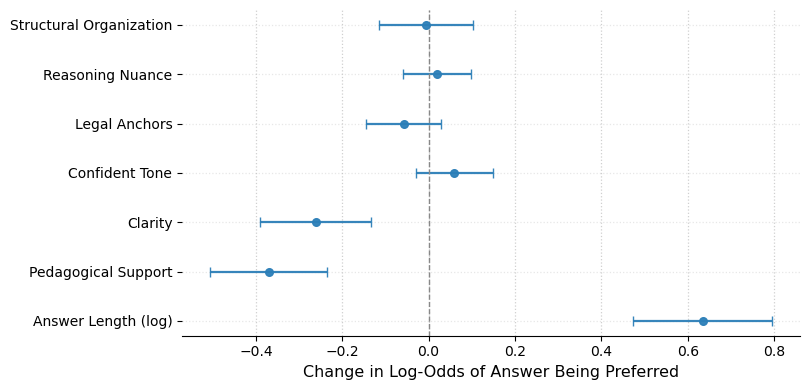


Preview predicted probabilities (head):
0    0.540732
1    0.268510
2    0.663693
3    0.590182
4    0.468986
dtype: float64


In [23]:
# ===== Inputs =====
df = pair_with_deltas.copy()

DELTA_FEATURES = [
    'delta_feat_legal_anchors_norm',
    'delta_feat_reasoning_nuance_rate',
    'delta_feat_tone_confidence_score',
    'delta_feat_clarity_simple',
    'delta_feat_length_log',
    'delta_feat_structural_combo',
    'delta_feat_pedagogical_combo',
]

def make_outcome(df: pd.DataFrame) -> pd.Series:
    """Construct binary outcome for pairwise choices.

    Returns ``1`` if answer A is preferred, ``0`` if B is preferred.
    Uses ``preferred_answer_id`` when available and falls back to
    the raw ``decision`` column as needed.
    """
    y = pd.Series(np.nan, index=df.index, dtype=float)

    has_ids = df['preferred_answer_id'].notna() & df['answer_key_a'].notna() & df['answer_key_b'].notna()
    y.loc[has_ids & (df['preferred_answer_id'] == df['answer_key_a'])] = 1.0
    y.loc[has_ids & (df['preferred_answer_id'] == df['answer_key_b'])] = 0.0

    if 'decision' in df.columns:
        undecided = y.isna()
        dec = df.loc[undecided, 'decision']
        y.loc[undecided & dec.astype(str).str.upper().eq('A')] = 1.0
        y.loc[undecided & dec.astype(str).str.upper().eq('B')] = 0.0
        y.loc[undecided & (dec == 1)] = 1.0
        y.loc[undecided & (dec == 0)] = 0.0
        y.loc[undecided & dec.astype(str).str.lower().eq('answer_a')] = 1.0
        y.loc[undecided & dec.astype(str).str.lower().eq('answer_b')] = 0.0

    return y.astype(float)

def fit_noFE_logit_for_deltas(df: pd.DataFrame):
    """
    Logit on Δ-features only (no fixed effects), for prediction.
    Returns the fitted model, column names, and aligned cluster IDs.
    """
    y_all = make_outcome(df)
    keep = y_all.notna()
    y = y_all[keep]
    X = df.loc[keep, DELTA_FEATURES].astype(float)

    # Add intercept
    Xc = sm.add_constant(X, has_constant='add')

    # Fit Logit
    model = sm.Logit(y, Xc, missing='drop')
    res = model.fit(disp=False, maxiter=200)

    # Two clustering dimensions (aligned with the kept rows)
    g_judge = df.loc[keep, 'judge_name'].astype('category').cat.codes.to_numpy()
    g_pair  = df.loc[keep, 'pair_key'].astype('category').cat.codes.to_numpy()

    colnames = Xc.columns.tolist()
    return res, colnames, g_judge, g_pair, Xc, y

def extract_table(params, cov, colnames, keep_features=True):
    """
    Build coef/SE/z/p/CI table from params and covariance.
    """
    params = np.asarray(params)
    cov = np.asarray(cov)
    se = np.sqrt(np.diag(cov))
    z = params / se
    p = 2 * (1 - norm.cdf(np.abs(z)))
    ci_low = params - 1.96 * se
    ci_high = params + 1.96 * se

    out = pd.DataFrame({
        'term': colnames,
        'coef': params,
        'se': se,
        'z': z,
        'p': p,
        'ci_low': ci_low,
        'ci_high': ci_high,
    })
    if keep_features:
        out = out[out['term'].isin(DELTA_FEATURES)].copy()
    return out

def twoway_cluster_cov(results, g1, g2):
    """
    Return just the 2D covariance matrix from cov_cluster_2groups,
    handling versions that return a tuple (cov, cov_g1, cov_g2, cov_inter) or similar.
    """
    out = cov_cluster_2groups(results, g1, g2)
    # Some versions return just the matrix; others return a tuple where [0] is the matrix
    if isinstance(out, (list, tuple)):
        cov = out[0]
    else:
        cov = out
    cov = np.asarray(cov)
    if cov.ndim != 2:
        raise ValueError(f"Two-way cluster covariance has wrong dim: {cov.ndim}")
    return cov

from statsmodels.stats.sandwich_covariance import cov_cluster_2groups

# --- after fitting ---
logit_res, cols, g_judge, g_pair, Xc, y = fit_noFE_logit_for_deltas(df)

# compute two-way clustered covariance directly
cov_both = twoway_cluster_cov(logit_res, g_judge, g_pair)
# build your table from params + custom cov
tab_cl_both = extract_table(logit_res.params, cov_both, cols)

# Optional: inspect table and significance
def stars(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '.' if p < 0.10 else ''

sig_table = (tab_cl_both
             .assign(sig=lambda d: d['p'].apply(stars))
             .loc[:, ['term','coef','se','p','ci_low','ci_high','sig']]
             .sort_values('p'))
print("\nTwo-way clustered (judge, pair) — Logit coefficients:")
print(sig_table.to_string(index=False))

FEATURE_NAME_MAP = {
    "delta_feat_structural_combo":     "Structural Organization",
    "delta_feat_reasoning_nuance_rate":"Reasoning Nuance",
    "delta_feat_legal_anchors_norm":   "Legal Anchors",
    "delta_feat_tone_confidence_score":"Confident Tone",
    "delta_feat_clarity_simple":       "Clarity",
    "delta_feat_pedagogical_combo":    "Pedagogical Support",
    "delta_feat_length_log":           "Answer Length (log)",
}


# === Plot (same style, but for Logit) ===
def plot_coef_intervals_logit(df_tab, sort_by='abs', title='Δ-Feature effects (Logit, two-way cluster SEs)', name_map=FEATURE_NAME_MAP):
    """
    df_tab columns: term, coef, ci_low, ci_high
    """
    base = df_tab.copy()
    base["term_pretty"] = base["term"].map(name_map).fillna(base["term"])

    # Order features
    if sort_by == 'abs':
        order = base.assign(abscoef=lambda r: r['coef'].abs()).sort_values('abscoef', ascending=False)['term_pretty'].tolist()
    elif isinstance(sort_by, list):
        order = sort_by
    else:
        order = base['term_pretty'].tolist()

    base['term_pretty'] = pd.Categorical(base['term_pretty'], categories=order, ordered=True)
    base = base.sort_values('term_pretty')

    #x = np.arange(len(order))
    y = np.arange(len(order))
    
    point_color = "#2C7FB8"   # steel/blue accent
    line_color  = "#2C7FB8"
    
    fig_h = max(4, 0.55 * len(order))
    
    fig, ax = plt.subplots(figsize=(8.2, fig_h))
    
    # CIs + point estimates
    x = base['coef'].values
    xerr = np.vstack([x - base['ci_low'].values, base['ci_high'].values - x])
    ax.errorbar(x, y, xerr=xerr, fmt='o', color=point_color, ecolor=line_color,
                elinewidth=1.6, capsize=3.5, markersize=5.5, alpha=0.95)

    ax.axvline(0, color="#888888", linestyle="--", linewidth=1)
    
    # Y labels and grid
    ax.set_yticks(y)
    ax.set_yticklabels(order)
    ax.grid(axis='x', linestyle=':', linewidth=0.9, alpha=0.6)
    ax.grid(axis='y', linestyle=':', linewidth=0.9, alpha=0.3)
    
    # Axis labels / title
    ax.set_xlabel("Change in Log-Odds of Answer Being Preferred", fontsize=11.5)
    #ax.set_title(title, fontsize=12.5, pad=8)
    
    # Clean spines
    for spine in ['top','right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Tight + padding
    plt.tight_layout()
    plt.show()
    
plot_coef_intervals_logit(
    tab_cl_both,
    sort_by='abs',
    title='Δ-Feature effects with two-way clustered SEs (Logit)'
)

# === Predictions (in-sample) ===
# Use these for evaluation or downstream analyses (ROC/AUC, calibration, etc.)
y_pred_prob = logit_res.predict(Xc)
print("\nPreview predicted probabilities (head):")
print(y_pred_prob.head())